
--- Base SVR Model ---
MSE: 5.8683, RMSE: 2.4225, MAE: 1.9084, R²: 0.8355, MAPE: 1964843893913368.75%

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV completed.

Best Hyperparameters found: {'C': np.float64(1232.9098365270513), 'epsilon': np.float64(0.052754101835854966), 'gamma': np.float64(0.00011919481947918739), 'kernel': 'rbf'}

--- Tuned SVR Model ---
MSE: 3.5478, RMSE: 1.8836, MAE: 1.4544, R²: 0.9005, MAPE: 792586111918574.38%


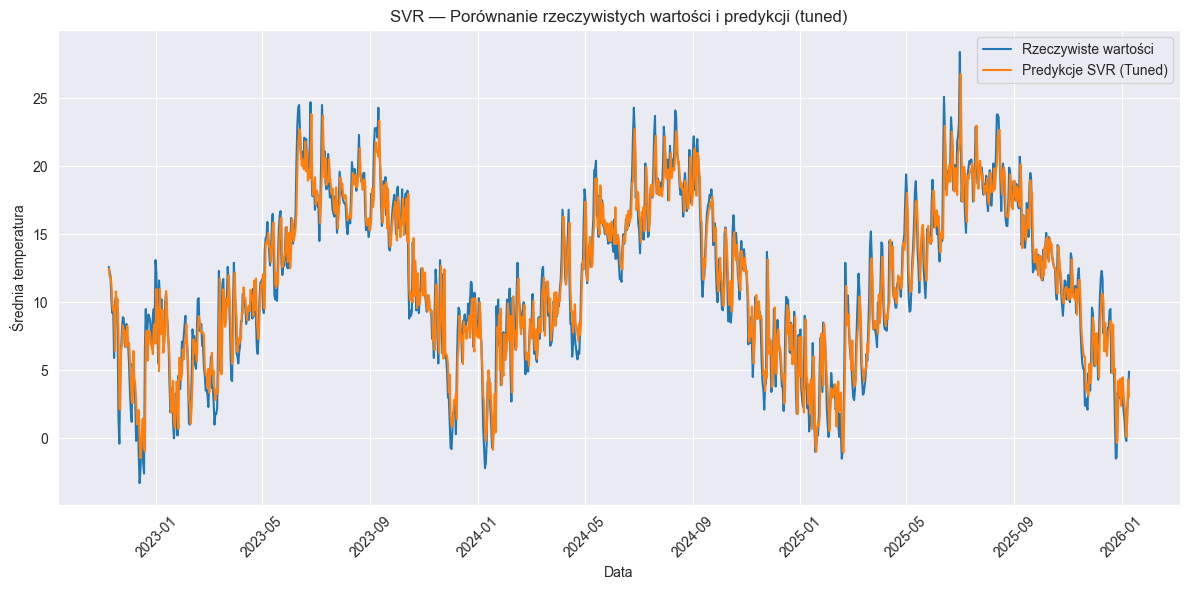

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import loguniform, uniform
import matplotlib.pyplot as plt

# =========================
# Ścieżka do pliku
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])

# =========================
# Filtrujemy dane dla Warszawy i dodajemy cechy czasowe
# =========================
df_city = df[df['city'] == 'Warszawa'].copy()
df_city['month'] = df_city['date'].dt.month
df_city['weekday'] = df_city['date'].dt.weekday
df_city = df_city[['date', 'tavg', 'month', 'weekday']]
df_city.sort_values("date", inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================
def create_sequences(df, window=60):
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq_tavg = df['tavg'].iloc[i:i+window].values
        seq_month = df['month'].iloc[i:i+window].values
        seq_weekday = df['weekday'].iloc[i:i+window].values
        seq = np.column_stack((seq_tavg, seq_month, seq_weekday))
        sequences.append(seq.flatten())
        labels.append(df['tavg'].iloc[i + window])
    return np.array(sequences), np.array(labels)

window = 60
sequences, labels = create_sequences(df_city, window=window)

# =========================
# Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(sequences)
y_scaled = scaler_y.fit_transform(labels.reshape(-1,1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(X_scaled) * 0.8)
X_train_scaled = X_scaled[:train_size]
X_test_scaled  = X_scaled[train_size:]
y_train_scaled = y_scaled[:train_size]
y_test_scaled  = y_scaled[train_size:]

# =========================
# Podstawowy SVR
# =========================
base_svr = SVR(kernel='rbf', C=10000, gamma='scale')
base_svr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_scaled = base_svr.predict(X_test_scaled)
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + np.finfo(float).eps))) * 100

print("\n--- Base SVR Model ---")
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# =========================
# RandomizedSearchCV - tuning SVR
# =========================
param_dist = {
    'C': loguniform(1e1, 1e5),
    'gamma': loguniform(1e-4, 1e-1),
    'epsilon': uniform(0.01, 0.1),
    'kernel': ['rbf']
}

random_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_dist,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train_scaled.ravel())
print("RandomizedSearchCV completed.")

best_params = random_search.best_params_
print("\nBest Hyperparameters found:", best_params)

# =========================
# Trening SVR z najlepszymi hiperparametrami
# =========================
best_svr = SVR(**best_params)
best_svr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_scaled_tuned = best_svr.predict(X_test_scaled)
y_pred_original_tuned = scaler_y.inverse_transform(y_pred_scaled_tuned.reshape(-1,1)).ravel()

mse_tuned = mean_squared_error(y_test_original, y_pred_original_tuned)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test_original, y_pred_original_tuned)
r2_tuned = r2_score(y_test_original, y_pred_original_tuned)
mape_tuned = np.mean(np.abs((y_test_original - y_pred_original_tuned) / (y_test_original + np.finfo(float).eps))) * 100

print("\n--- Tuned SVR Model ---")
print(f"MSE: {mse_tuned:.4f}, RMSE: {rmse_tuned:.4f}, MAE: {mae_tuned:.4f}, R²: {r2_tuned:.4f}, MAPE: {mape_tuned:.2f}%")

# =========================
# Wykres rzeczywiste vs predykcje
# =========================
plt.figure(figsize=(12,6))
plt.plot(df_city['date'].iloc[-len(y_test_original):], y_test_original, label='Rzeczywiste wartości')
plt.plot(df_city['date'].iloc[-len(y_pred_original_tuned):], y_pred_original_tuned, label='Predykcje SVR (Tuned)')
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.title("SVR — Porównanie rzeczywistych wartości i predykcji (tuned)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# Ścieżka do pliku
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])

# =========================
# Filtrujemy dane dla Warszawy
# =========================
df_city = df[df['city'] == 'Warszawa'][['date','tavg']].copy()
df_city.sort_values("date", inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================
def create_sequences(df, window=60):
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df['tavg'].iloc[i:i+window].values
        label = df['tavg'].iloc[i + window]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window = 60
sequences, labels = create_sequences(df_city, window=window)

# =========================
# Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(sequences)
y_scaled = scaler_y.fit_transform(labels.reshape(-1,1))

# =========================
# Walk-Forward Cross-Validation dla SVR
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores = []
mse_scores = []
r2_scores = []

fold = 1

for train_index, test_index in tscv.split(X_scaled):
    print(f"\nFold {fold}")
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    
    # =========================
    # Trening SVR z najlepszymi parametrami
    # =========================
    svr = SVR(
        kernel='rbf',
        C=1232.91,
        gamma=0.0001192,
        epsilon=0.05275
    )
    svr.fit(X_train, y_train.ravel())
    
    y_pred_scaled = svr.predict(X_test).reshape(-1,1)
    
    # Odwrócenie skalowania
    y_test_rescaled = scaler_y.inverse_transform(y_test)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
    
    mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2   = r2_score(y_test_rescaled, y_pred_rescaled)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")
    
    fold += 1

# =========================
# Podsumowanie cross-validation
# =========================
print("\nWalk-Forward Cross-Validation — SVR (tuned parameters)")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



Fold 1
R²: 0.8973 | MAE: 1.4606 | MSE: 3.5003 | RMSE: 1.8709

Fold 2
R²: 0.8990 | MAE: 1.4458 | MSE: 3.5090 | RMSE: 1.8732

Fold 3
R²: 0.9010 | MAE: 1.5250 | MSE: 3.7099 | RMSE: 1.9261

Fold 4
R²: 0.8922 | MAE: 1.4126 | MSE: 3.4374 | RMSE: 1.8540

Fold 5
R²: 0.8997 | MAE: 1.4618 | MSE: 3.5400 | RMSE: 1.8815

Walk-Forward Cross-Validation — SVR (tuned parameters)
R²   : 0.8978
MAE  : 1.4612
MSE  : 3.5393
RMSE : 1.8812


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym SVR
# =========================
y_pred_scaled = best_model.predict(X_test).reshape(-1,1)

# Odwrócenie skalowania
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Dopasowanie długości (czasem może być minimalna różnica)
min_len = min(len(y_test_rescaled), len(y_pred_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
y_pred_rescaled = y_pred_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - y_pred_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['date'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='g'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu SVR — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='g')
plt.title('Rozkład residuals modelu SVR')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'best_model' is not defined

In [14]:
from sklearn.multioutput import MultiOutputRegressor

# Tworzenie etykiet multi-step (5 dni)
forecast_horizon = 5
X_multi, y_multi = [], []
for i in range(len(df_city) - window - forecast_horizon + 1):
    X_multi.append(df_city['tavg'].iloc[i:i+window].values)
    y_multi.append(df_city['tavg'].iloc[i+window:i+window+forecast_horizon].values)
X_multi = np.array(X_multi)
y_multi = np.array(y_multi)

# Skalowanie
X_scaled = scaler_X.fit_transform(X_multi)
y_scaled = scaler_y.fit_transform(y_multi)
y_scaled = np.array(y_scaled)

# Trening MultiOutput SVR
multi_svr = MultiOutputRegressor(SVR(kernel='rbf', C=1232.91, gamma=0.0001192, epsilon=0.05275))
multi_svr.fit(X_scaled, y_scaled)

# Predykcja 5 dni od razu
last_window = X_scaled[-1].reshape(1, window)
future_scaled = multi_svr.predict(last_window)
future_pred = scaler_y.inverse_transform(future_scaled)
print("Prognoza 5 dni (multi-output SVR):")
print(future_pred.flatten())


Prognoza 5 dni (multi-output SVR):
[2.23223505 3.08253823 3.54196626 3.83233086 3.99171008]
